#### Q1: Simulation 
Simulate Bid-ask spread dynamics for the following question: 
* The end-of-day value of a share of stock, V, is random
* At market close: either $V_H$=150 or $V_L$=100
    * With equal probability
* Before trading starts, the expected value is
    * EV=$\frac{1}{2}150 + \frac{1}{2} 100$=125
    * This is the unconditional expected value
* There are two types of traders
    * Informed traders know V
    * Uninformed (``retail'') traders don't know V
* The dealer doesn't know V
* Uninformed traders are equally likely to buy or sell
* Informed traders observe V and decide the optimal trading strategy 
* After the dealer sets the bid and ask quote, a trader arrives. 
    * Assuming: Prob(uninformed) = 0.8 and Prob(informed) = 0.2


Plot Bid-ask spread dynamics for the following two scenarios (b is buy order and s is sell order)
1) s,s,b,s,s,b,s,s,s,s,s,s
2) s,b,b,s,b,b,s,b,b,b,b,b


In [1]:
import matplotlib.pyplot as plt

v_h = 150
v_l = 100
theta = 0.5
prob_inf = 0.2

scenario_1 = ["s","s","b","s","s","b","s","s","s","s","s","s"]
scenario_2 = ["s","b","b","s","b","b","s","b","b","b","b","b"]

def generate_bid_ask(orders, v_h, v_l, theta, prob_inf):
    bid_prices, ask_prices = [], []

    for order in orders:
        if order == 'b':
            theta = theta*((1-prob_inf)*0.5 + prob_inf)/((1-prob_inf)*0.5 + prob_inf*theta)
            ask_price = v_h * theta + v_l * (1 - theta)
            e_v = theta * v_h + (1 - theta) * v_l
            bid_price = e_v - (theta * (1 - theta) * (v_h - v_l)) / ((1 - prob_inf) * 0.5 + prob_inf * (1 - theta))
        elif order == 's':
            theta = theta*((1-prob_inf)*0.5)/((1-prob_inf)*0.5 + prob_inf*(1-theta))
            bid_price = v_h * theta + v_l * (1 - theta)
            e_v = theta * v_h + (1 - theta) * v_l
            ask_price = e_v + (theta * (1 - theta) * (v_h - v_l)) / ((1 - prob_inf) * 0.5 + prob_inf * (1 - theta))
        bid_prices.append(bid_price)
        ask_prices.append(ask_price)


    plt.plot(ask_prices, label='Ask')
    plt.plot(bid_prices, label='Bid')
    plt.xlabel('Order #')
    plt.ylabel('Price')
    plt.title('Bid-ask spread dynamics')
    plt.legend()
    plt.show()
    return None

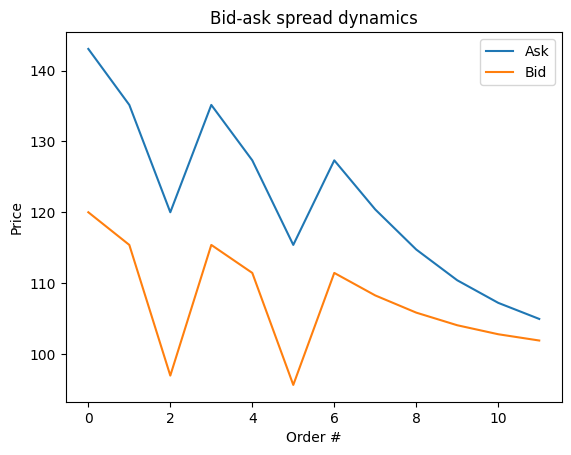

In [2]:
generate_bid_ask(scenario_1, v_h, v_l, theta, prob_inf)

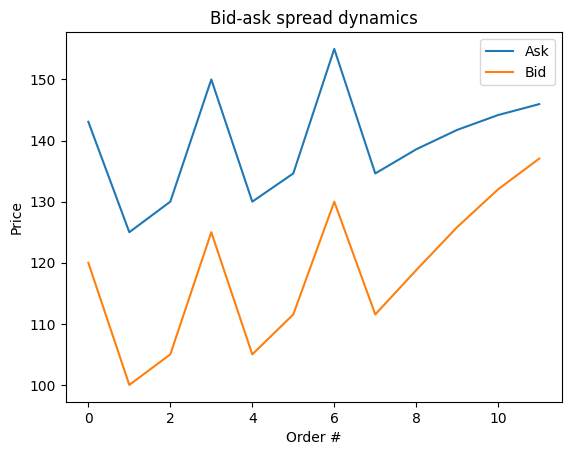

In [3]:
generate_bid_ask(scenario_2, v_h, v_l, theta, prob_inf)

#### Q2: Data cleanning and data analysis 
This exercise is about ﬁxed income markets. Corporate bonds are largely traded in OTC markets. Academic Corporate Bond TRACE Dataset contains historic transaction-level data on all eligible corporate bondsinvestment grade, high yield and convertible debt. We use this dataset to understand the bond market during the COVID-19 Crisis.

* bond.csv.zip is the dataset containing TRACE data downloaded from WRDS
* VariableList.csv contains the variable description, and more detailed description is in TRACE Variable.pdf
* I will not give you instructions to clean the data. You need to underrstand what variables to use and decide your way to handle the data 

##### Data Cleaning 
* How many different companies and corporate bonds are in the data set?

* Plot the histogram of the number of trading days 

* The data reports the contra-party type. 
    * Calculate spread for each trade as follows. Note that we do not see bid/ask prices at OTC markets, so the calculation of spread is not direct. We follow the calculation in
    $$spread = 2Q * \frac{traded price - reference price}{referenc price}$$
    where Q is +1 for a customer buy and −1 for a customer sell. For each trade, we calculate its reference price as the volume-weighted average price of trades in the same bond-day
    * Plot the histogram of calculated trade spread. Do you notice that 1) lots of spreads are exactly zero, 2) there are entries with very large spreads? Please answer why those spreads are zero? Give one example to explain outlier spreads (check news and list one example that may lead to large spreads)

##### Analysis
* Daily analysis 
    * Spread
        * Aggregate spread information to the company-day level. What is the reasonable way in your opinions to do this? 
        * Using bond-day level spreads to calculate the average spread for each stock and present the results. What can we learn from the ranking of the spreads?
        * Plot time-series spread using company-day level data for each company. What patterns do you see, and why is that?
    * Volume 
        * Calculate company-day trading volume for each company
        * Plot histogram of the company-day trading volume. What is the distribution? 
    * Analsyis
        * Does past trading volume predicts future spreads? 
        * Are daily trading volume time-series correlated? 


* Intraday analysis 
    * Spread
        * For each company, construct and plot the intraday spread pattern by minutes 
    * Volume 
        * For each company, construct and plot the intraday volume pattern by minutes 
    * Analysis 
        * Does the interday pattern change during market stress periods? 
        * Is intraday volume predictable? (Note that you can also construct interday return information)


#### Import the relevant modules

In [4]:
# !pip3 install datatable
# !pip3 install regpyhdfe

In [5]:
### In this project, I will use datatable (quicker) rather pandas to manipulate data. You can see which one is more intuitive for you 
from datetime import datetime
import datatable as dt
from datatable import dt, f, by, update
from regpyhdfe import Regpyhdfe
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [6]:
import pandas as pd
df = pd.read_csv("~/Downloads/TRACE/bond.csv")
print(df.head(2))

/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_15946/2412011580.py:2: DtypeWarning: Columns (16,22,27,30,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("~/Downloads/TRACE/bond.csv")


    cusip_id bond_sym_id company_symbol          bsym  trd_exctn_dt  \
0  903436AA1  AAL3604479            AAL  BBG001RYS1P3      20200107   
1  903436AA1  AAL3604479            AAL  BBG001RYS1P3      20200107   

  trd_exctn_tm sub_prd_type  trans_dt  msg_seq_nb trc_st  ...  rptd_last_pr  \
0     14:50:35         CORP  20200107       50555      M  ...           NaN   
1     14:50:35         CORP  20200107       50556      M  ...           NaN   

   lsal_yld_sign_cd lsal_yld_pt orig_dis_dt orig_msg_seq_nb  function  \
0               NaN         NaN         NaN             NaN       NaN   
1               NaN         NaN         NaN             NaN       NaN   

    sttl_dt  rptg_party_type contra_party_type  ATS_indicator  
0  20200109                D                 C            NaN  
1  20200109                D                 D            NaN  

[2 rows x 42 columns]


In [7]:
print("There are {} unique companies and {} unique corporate bonds in the dataset.".format(df.company_symbol.nunique(), df.cusip_id.nunique()))

There are 5 unique companies and 156 unique corporate bonds in the dataset.


<Axes: >

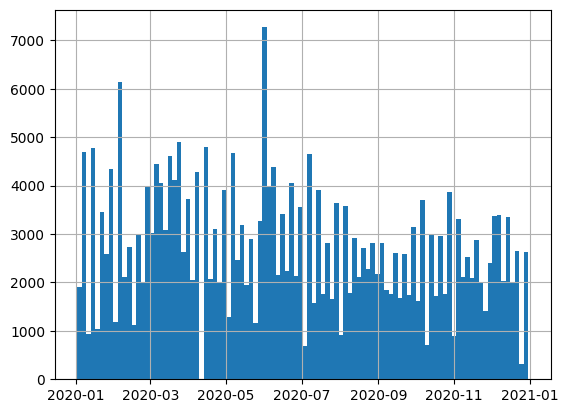

In [8]:
df['trd_exctn_dt'] = pd.to_datetime(df['trd_exctn_dt'], format='%Y%m%d')
df['trd_exctn_dt'].hist(bins=100)

In [9]:
def convert_to_numeric(value):
    try:
        if 'MM+' in value:
            return float(value.replace('MM+', '')) * 1e6
        else:
            return pd.to_numeric(value)
    except ValueError: 
        return None
df['ascii_rptd_vol_tx'] = df['ascii_rptd_vol_tx'].apply(convert_to_numeric)

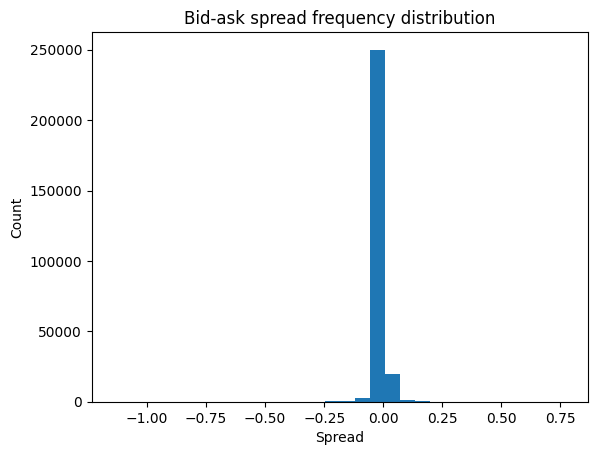

In [10]:
vwap_calculation = df.groupby(['trd_exctn_dt', 'cusip_id']).apply(lambda group: pd.Series({'reference_price': np.sum(group['ascii_rptd_vol_tx'] * group['rptd_pr']) / np.sum(group['ascii_rptd_vol_tx'])})).reset_index()
df = pd.merge(df, vwap_calculation, on=['trd_exctn_dt', 'cusip_id'], how='left')
df['numeric_trade_direction'] = np.where(df['side'] == 'B', 1, -1)
df['spread'] = 2 * df['numeric_trade_direction'] * (df['rptd_pr'] - df['reference_price']) / df['reference_price']
plt.hist(df['spread'], bins=30)
plt.xlabel('Spread')
plt.ylabel('Count')
plt.title('Bid-ask spread frequency distribution')
plt.show()

In [11]:
top_spreads = df.nlargest(20, 'spread')[['trd_exctn_dt', 'spread']]
print("Top 10 spreads: \n", top_spreads)

Top 10 spreads: 
        trd_exctn_dt    spread
196740   2020-10-19  0.771122
196757   2020-10-19  0.709326
195536   2020-03-18  0.650916
12159    2020-04-23  0.646667
192364   2020-10-14  0.636981
195648   2020-04-09  0.561678
191044   2020-04-15  0.540971
196755   2020-10-19  0.540195
195653   2020-04-13  0.537168
192051   2020-07-31  0.520019
192269   2020-10-05  0.512112
192272   2020-10-05  0.512112
10557    2020-10-05  0.495121
10558    2020-10-05  0.495121
194659   2020-10-14  0.491435
194689   2020-10-16  0.454984
194690   2020-10-16  0.454984
194691   2020-10-16  0.454984
6007     2020-07-06  0.449337
192267   2020-10-05  0.447421


Bid-ask spreads widen when there is a sudden news or a sudden influx of informed traders trading on new information. And the spread could also be zero when a trade occurs at a single price.

In [12]:
df['trans_dt'] = pd.to_datetime(df['trans_dt'], format='%Y%m%d')
company_grouped_df = df.groupby(['company_symbol', 'trans_dt'])
company_agg_df = company_grouped_df.agg({'spread': ['mean']}).reset_index()
company_agg_df['spread_mean'] = company_agg_df['spread']['mean']
df_new = company_agg_df.drop('spread_mean', axis=1)
print(df_new.head())

  company_symbol   trans_dt    spread
                                 mean
0            AAL 2020-01-02 -0.000087
1            AAL 2020-01-03 -0.001666
2            AAL 2020-01-06 -0.001445
3            AAL 2020-01-07  0.000030
4            AAL 2020-01-08 -0.002526


/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_15946/1192484489.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_new = company_agg_df.drop('spread_mean', axis=1)


In [13]:
grouped_df = df.groupby(['cusip_id', 'trans_dt'])
mean_per_day = grouped_df.agg({'spread': ['mean']}).reset_index()
mean_per_day.head()

,cusip_id,trans_dt,spread
,,,mean
0,00165AAH1,2020-01-02,-0.015301
1,00165AAH1,2020-01-03,-0.006427
2,00165AAH1,2020-01-06,-0.003338
3,00165AAH1,2020-01-07,-0.014871
4,00165AAH1,2020-01-08,-0.025803


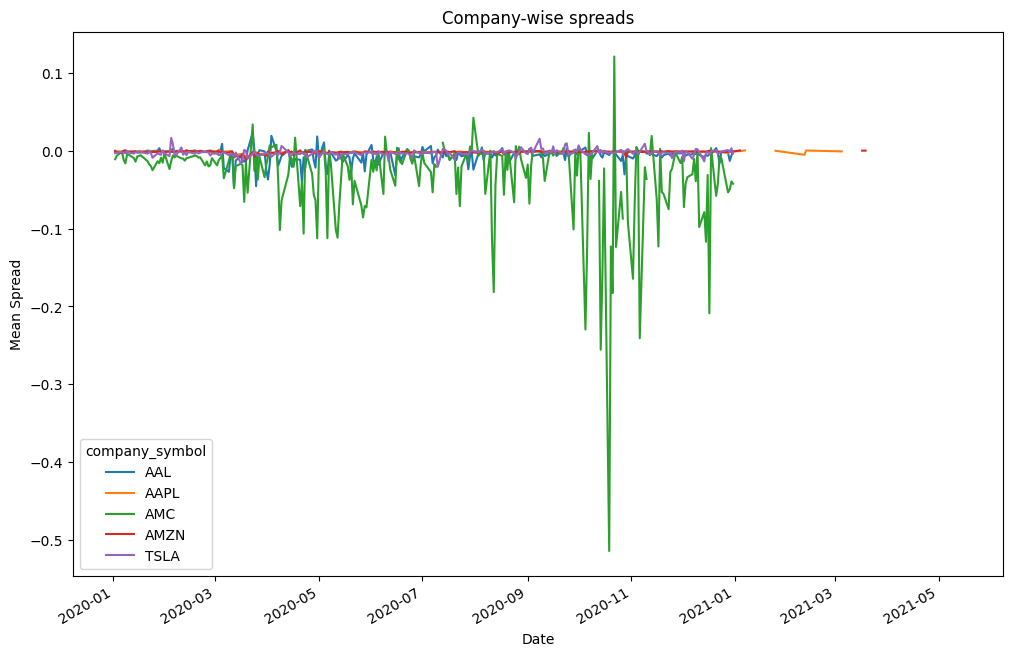

In [14]:
spread_time_series = company_agg_df.pivot(index='trans_dt', columns='company_symbol', values='spread_mean')
spread_time_series.plot(figsize=(12, 8), legend=True)
plt.title('Company-wise spreads')
plt.xlabel('Date')
plt.ylabel('Mean Spread')
plt.show()

AMC has the most volatile bid-ask spreads also give us an idea about the liquidity of thes ebonds that we traded. The difference could be due to supply demand or trading activity as compared to other companies.

/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_15946/2470805026.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_company['company_day_level_volume'] /= 1e6


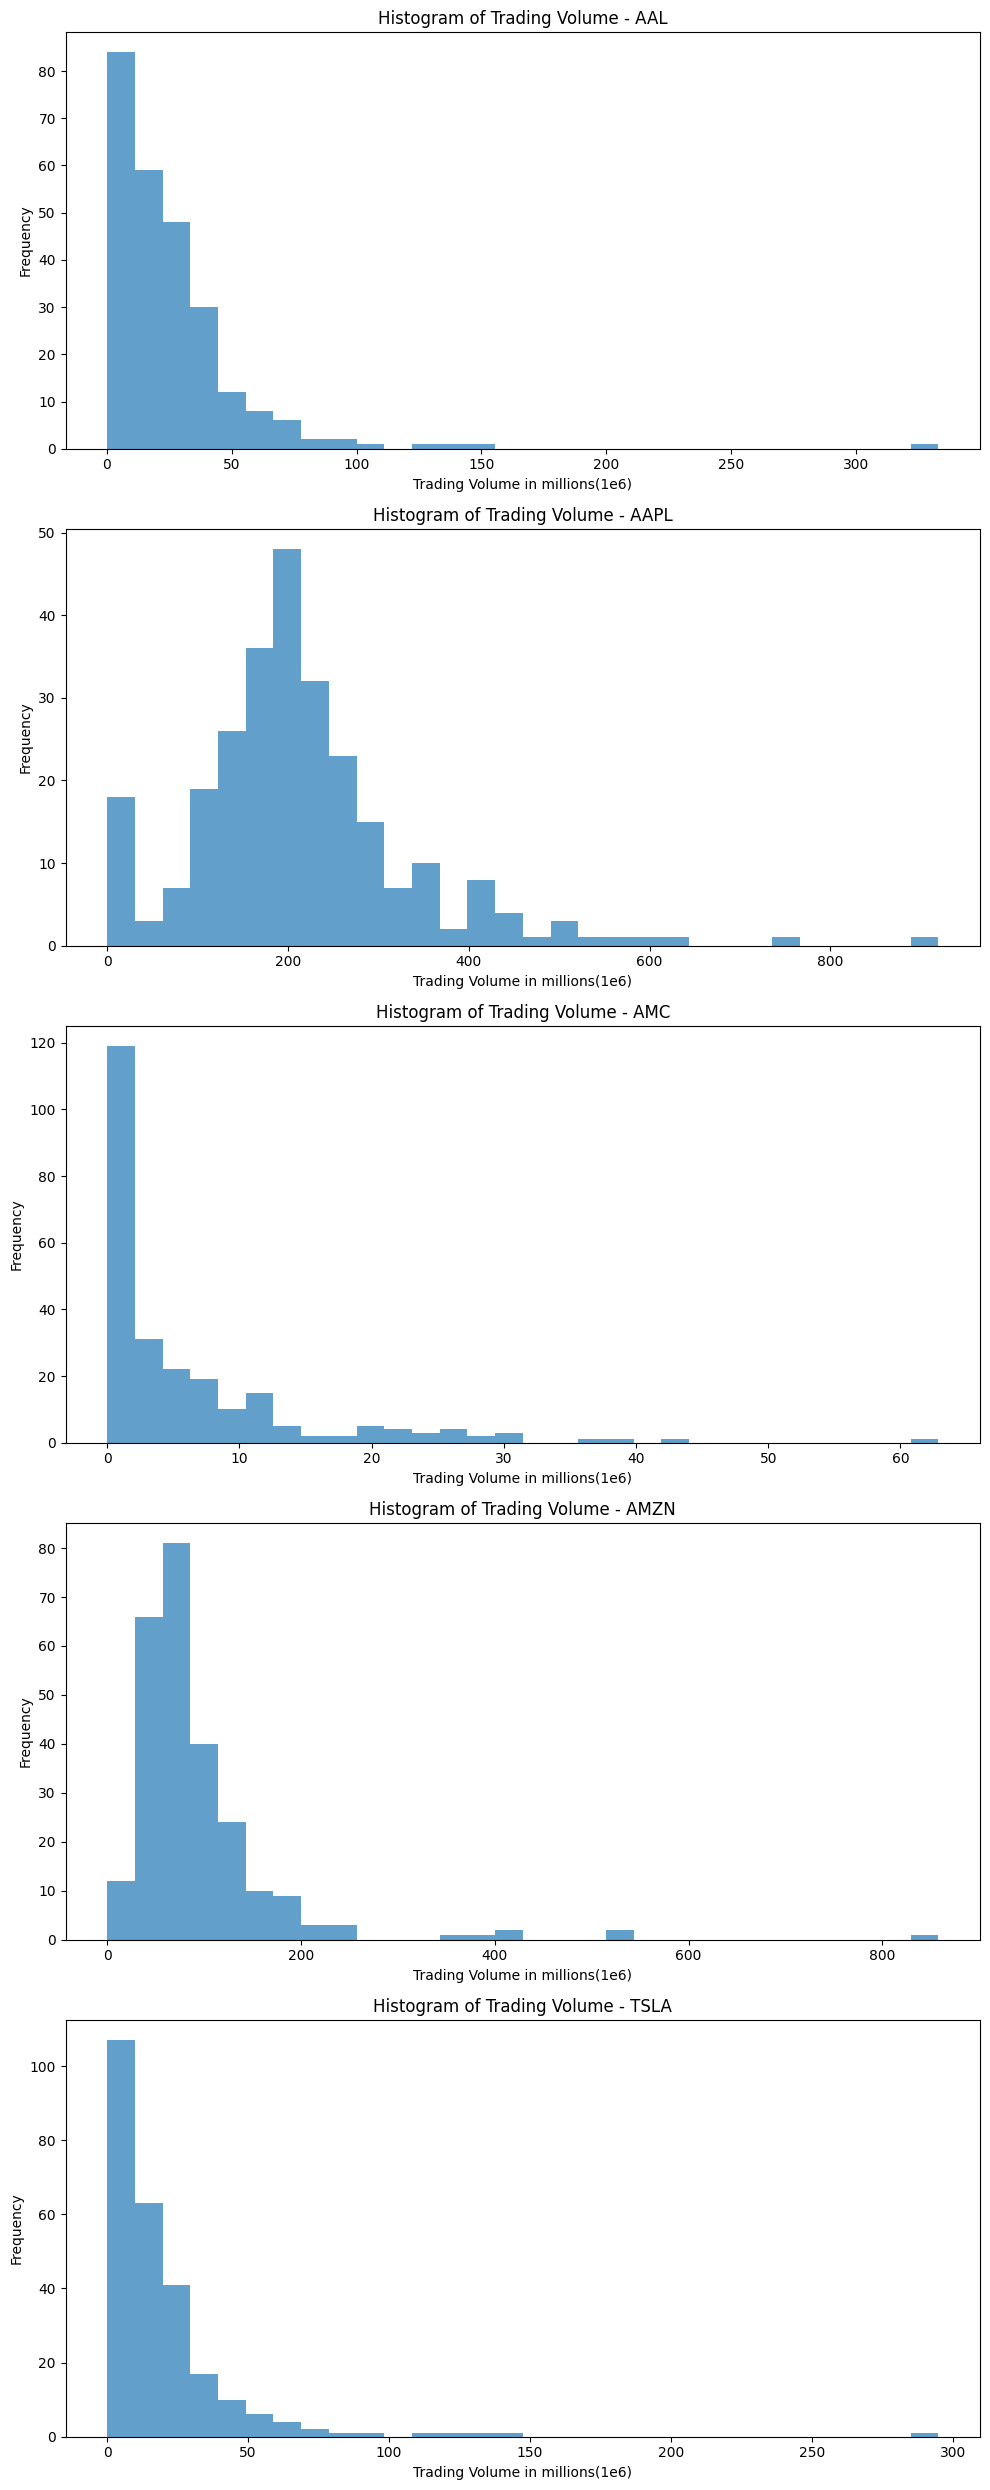

In [15]:
company_day_level_volume = df.groupby(['company_symbol', 'trd_exctn_dt'])['ascii_rptd_vol_tx'].sum().reset_index()
company_day_level_volume = company_day_level_volume.rename(columns={'ascii_rptd_vol_tx': 'company_day_level_volume'})
unique_companies = company_day_level_volume['company_symbol'].unique()
fig, axes = plt.subplots(nrows=len(unique_companies), figsize=(10, 5 *len(unique_companies)))
for i, company in enumerate(unique_companies):
    data_for_company = company_day_level_volume[company_day_level_volume['company_symbol'] == company]
    data_for_company['company_day_level_volume'] /= 1e6
    axes[i].hist(data_for_company['company_day_level_volume'], bins=30, alpha=0.7)
    axes[i].set_title(f'Histogram of Trading Volume - {company}')
    axes[i].set_xlabel('Trading Volume in millions(1e6)')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

Bid-ask spreads and Trading volumes mostly follow an inverse correlation. Higher volume often results in lower spreads and vice-versa.

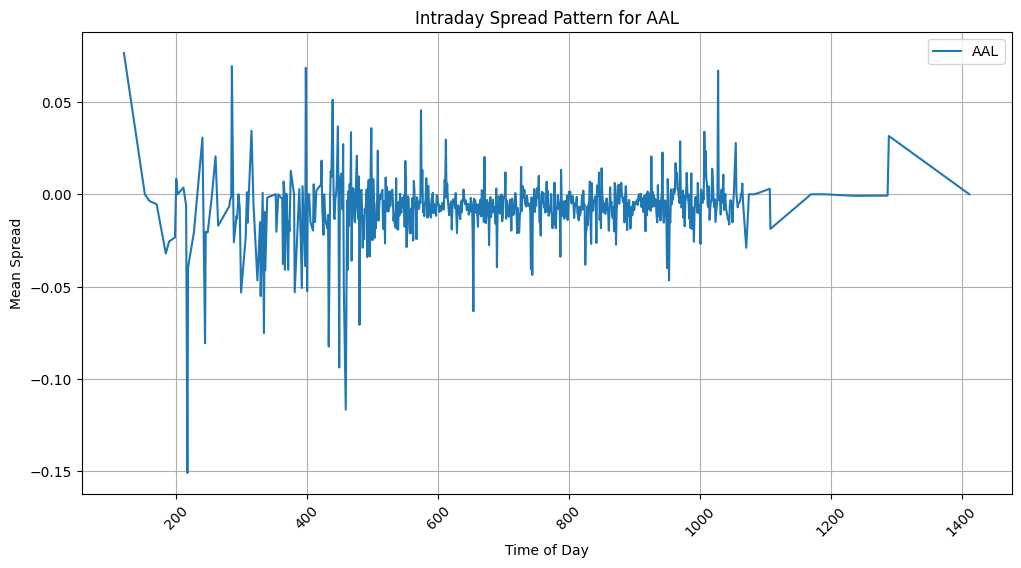

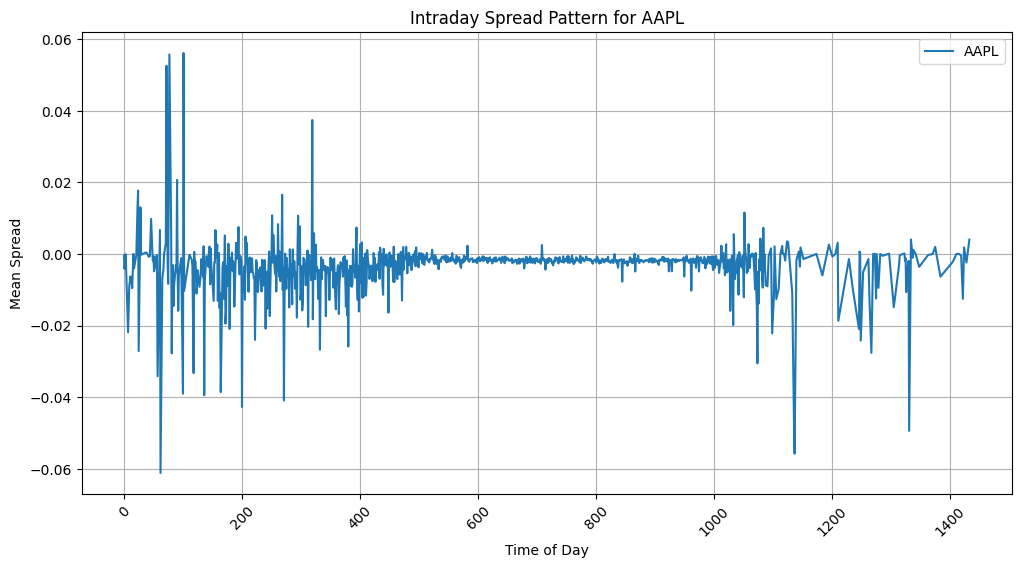

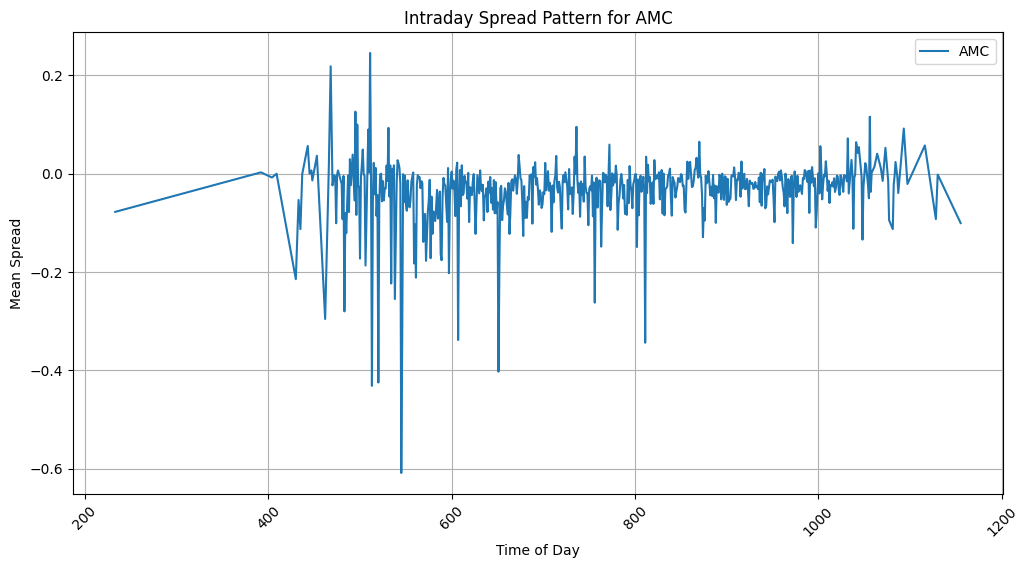

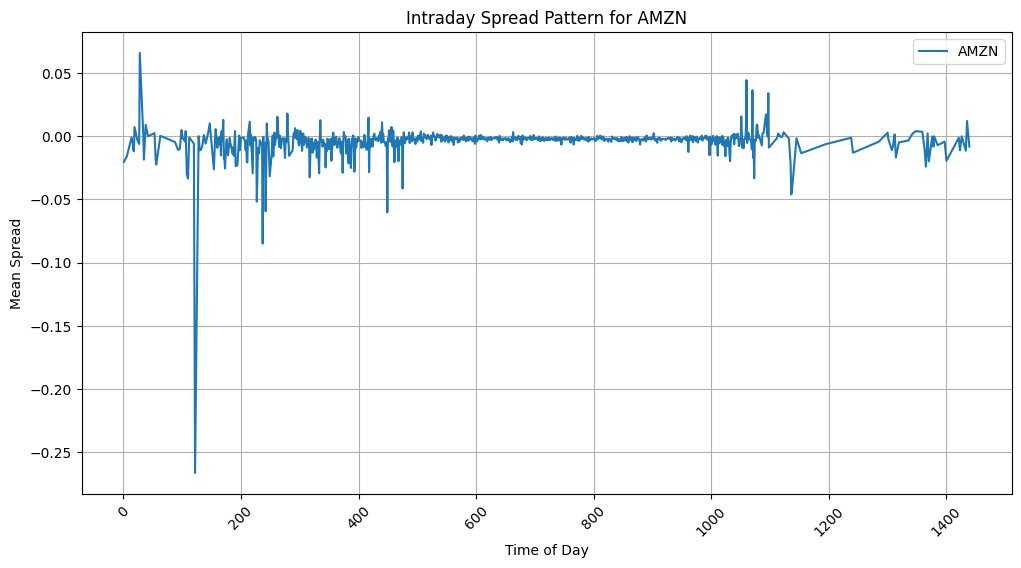

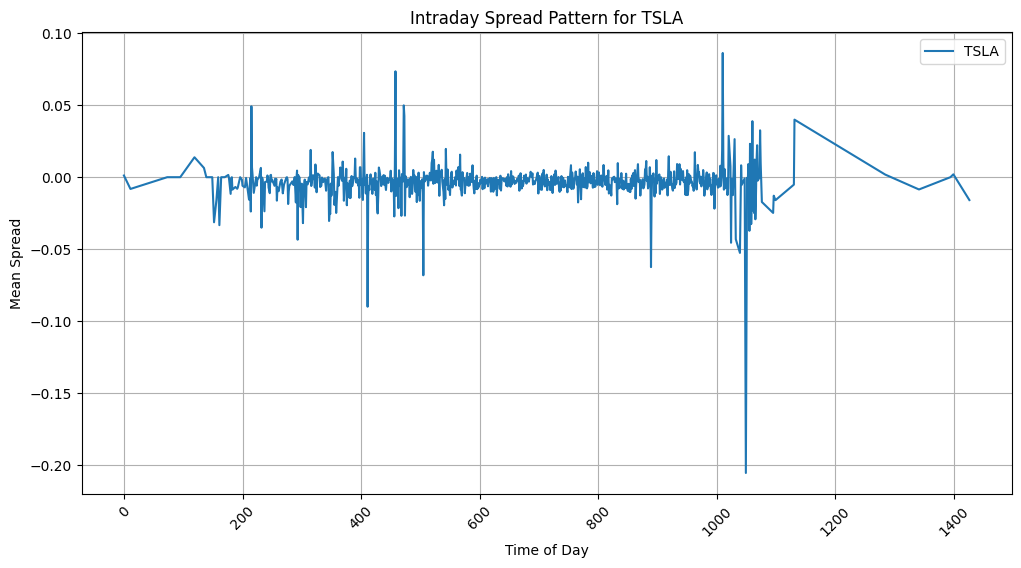

In [16]:
intraday_df = df[['company_symbol', 'trd_exctn_tm', 'spread','ascii_rptd_vol_tx']]
unique_companies = intraday_df['company_symbol'].unique()
for company_symbol in unique_companies:
    company_data = intraday_df[intraday_df['company_symbol'] == company_symbol]
    company_data = company_data.sort_values(by='trd_exctn_tm', ascending=False)
    company_data['trd_exctn_tm'] = pd.to_datetime(company_data['trd_exctn_tm'], format='%H:%M:%S').dt.time
    company_data['minute'] = pd.to_datetime(company_data['trd_exctn_tm'], format='%H:%M:%S').dt.minute
    company_data['hour'] = pd.to_datetime(company_data['trd_exctn_tm'], format='%H:%M:%S').dt.hour
    company_data['day_minute'] = company_data['hour']*60 + company_data['minute']
    minute_spread = company_data.groupby(['day_minute'])['spread'].mean().reset_index()
    minute_spread['time'] = minute_spread['day_minute'].apply(lambda x: f"{x //60:02d}:{x % 60:02d}")
    plt.figure(figsize=(12, 6))
    plt.plot(minute_spread['day_minute'], minute_spread['spread'], linestyle='-', label=company_symbol)
    plt.title(f'Intraday Spread Pattern for {company_symbol}')
    plt.xlabel('Time of Day')
    plt.ylabel('Mean Spread')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

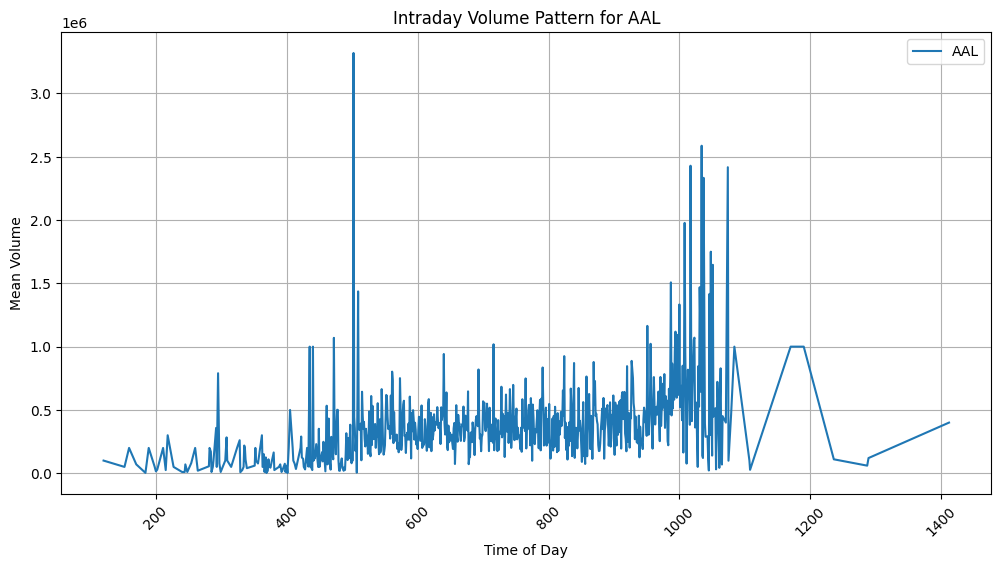

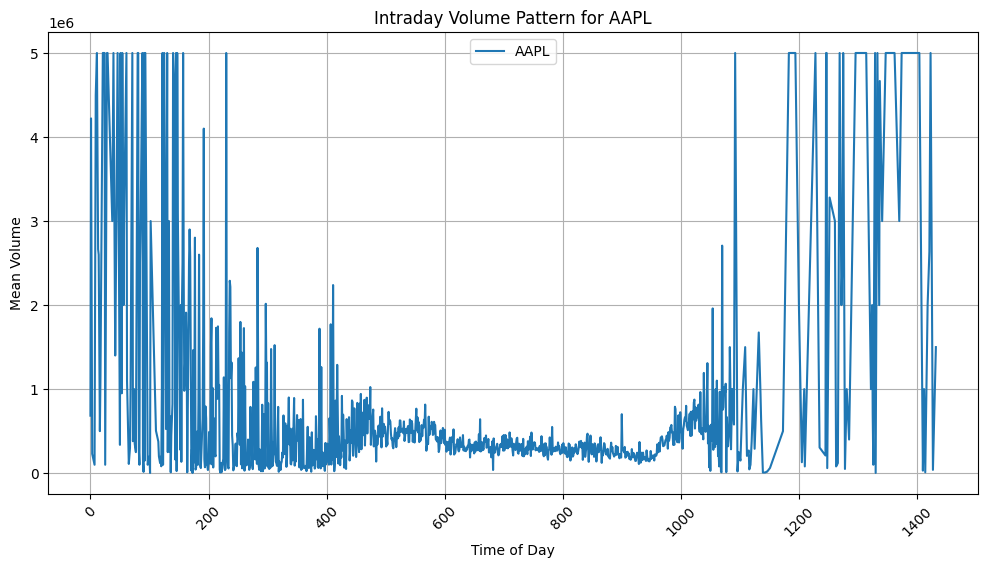

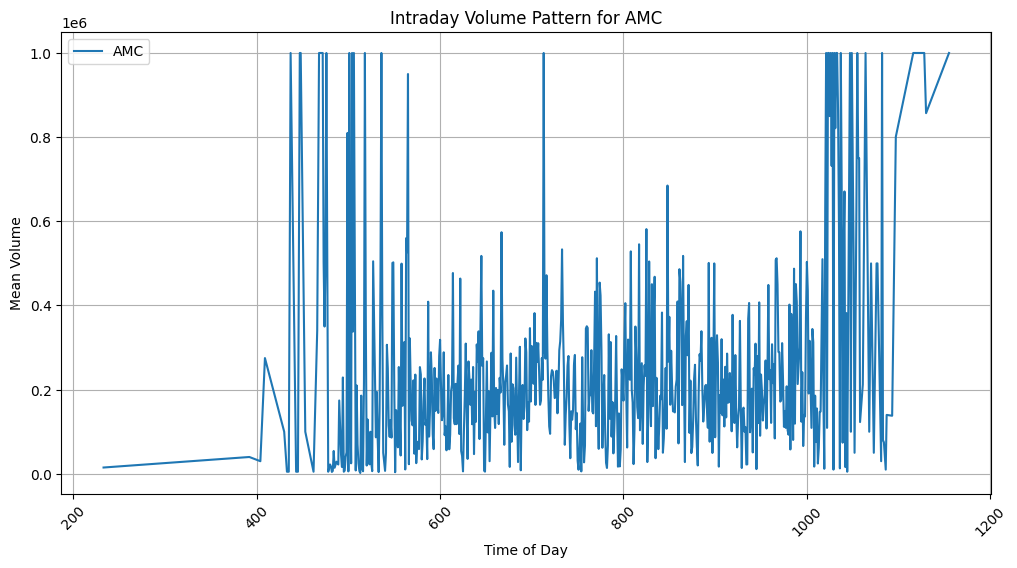

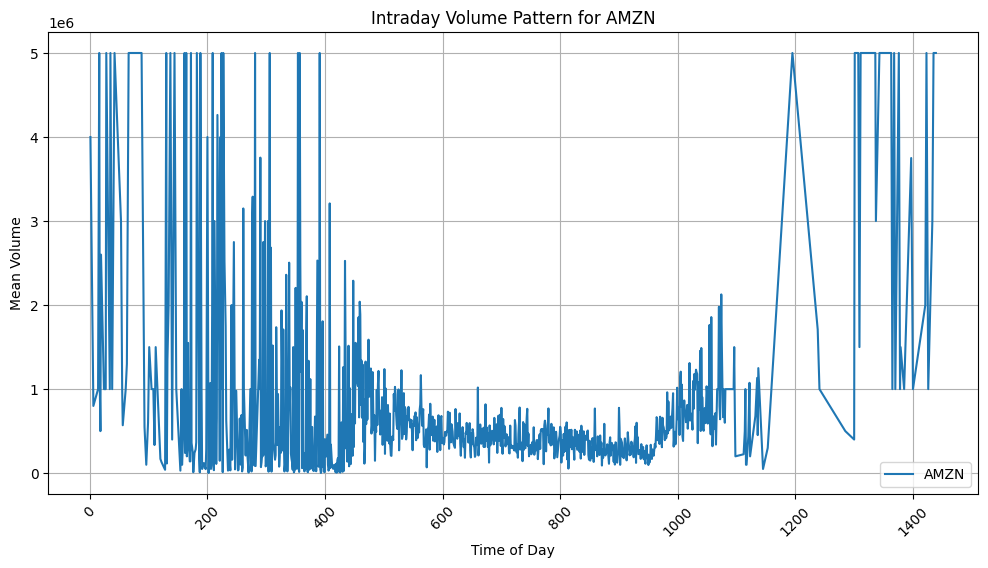

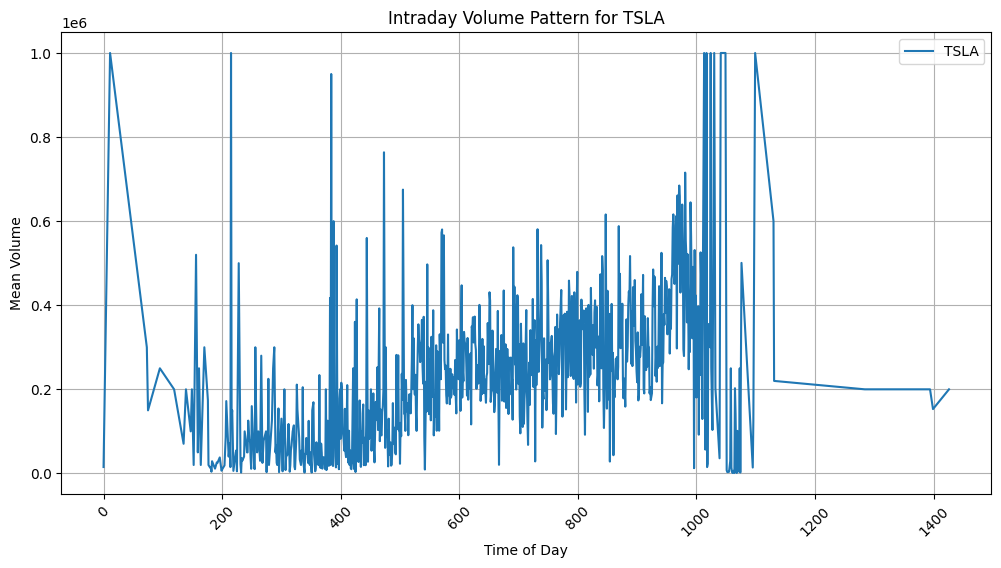

In [17]:
intraday_df = df[['company_symbol', 'trd_exctn_tm', 'spread','ascii_rptd_vol_tx']]
unique_companies = intraday_df['company_symbol'].unique()
for company_symbol in unique_companies:

    company_data = intraday_df[intraday_df['company_symbol'] == company_symbol]
    company_data = company_data.sort_values(by='trd_exctn_tm', ascending=False)
    company_data['trd_exctn_tm'] = pd.to_datetime(company_data['trd_exctn_tm'], format='%H:%M:%S').dt.time
    company_data['minute'] = pd.to_datetime(company_data['trd_exctn_tm'], format='%H:%M:%S').dt.minute
    company_data['hour'] = pd.to_datetime(company_data['trd_exctn_tm'], format='%H:%M:%S').dt.hour
    company_data['day_minute'] = company_data['hour']*60 + company_data['minute']
    minute_spread = company_data.groupby(['day_minute'])['ascii_rptd_vol_tx'].mean().reset_index()
    minute_spread['time'] = minute_spread['day_minute'].apply(lambda x: f"{x // 60:02d}:{x % 60:02d}")
    plt.figure(figsize=(12, 6))
    plt.plot(minute_spread['day_minute'], minute_spread['ascii_rptd_vol_tx'], linestyle='-', label=company_symbol)
    plt.title(f'Intraday Volume Pattern for {company_symbol}')
    plt.xlabel('Time of Day')
    plt.ylabel('Mean Volume')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

Trading volumes are at their highest near opening and closing of the markets.